# Faster RCNN
https://www.programmersought.com/article/42951547597/    
https://www.programmersought.com/article/55757970119/    
https://www.programmersought.com/article/73024986477/    
https://towardsdatascience.com/faster-rcnn-object-detection-f865e5ed7fc4  
- https://whatdhack.medium.com/a-deeper-look-at-how-faster-rcnn-works-84081284e1cd#:~:text=%20A%20deeper%20look%20at%20how%20Faster-RCNN%20works,can%20be%20considered%20the%20removed%20layers...%20More%20

## Introduction 
<span class="mark">Faster RCNN is an object detection architecture</span> presented by Ross Girshick, Shaoqing Ren, Kaiming He and Jian Sun in 2015, and is one of the famous object detection architectures that uses convolution neural networks like YOLO (You Look Only Once) and SSD ( Single Shot Detector)     
**Faster RCNN is composed from 3 parts**    
- Feature Network,   
- Region Proposal Network (RPN),  
- Detection Network  

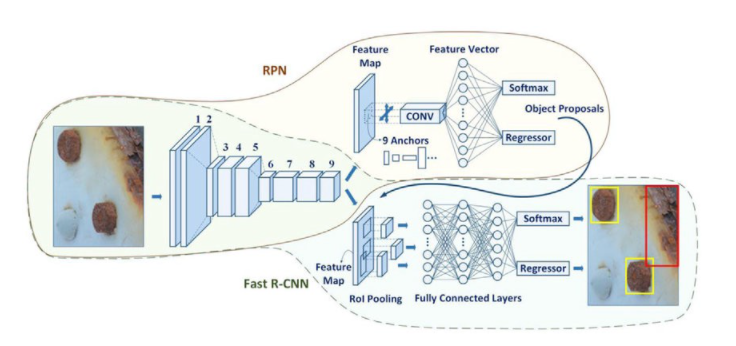
### Part 1 : Convolution layers or Feature Network
In this layers we train filters to extract the appropriate features from the image, for example let’s say that we are going to train those filters to extract the appropriate features for a human face, then those filters are going to learn through out training shapes and colors that only exist in the human face.    

- Convolution networks are generally composed of Convolution layers, pooling layers and a last component which is the fully connected or another extended thing that will be used for an appropriate task like classification or detection.   
- The Feature Network is usually a well known pre-trained image classification network such as VGG minus a few last/top layers. The function of this network is to generate good features from the images. The output of this network maintains the the shape and structure of the original image 

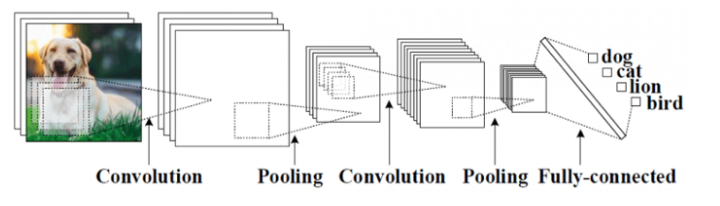
We compute convolution by sliding filter all along our input image and the result is a two dimension matrix called **feature map.**     

**feature map=** The feature maps of a CNN capture the result of applying the filters to an input image. I.e at each layer, the feature map is the output of that layer. The reason for visualising a feature map for a specific input image is to try to gain some understanding of what features our CNN detects.

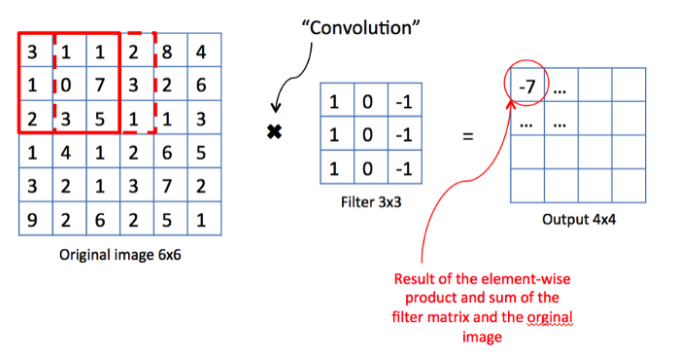
**Pooling consists of decreasing quantity of features in the features map by eliminating pixels with low values.**

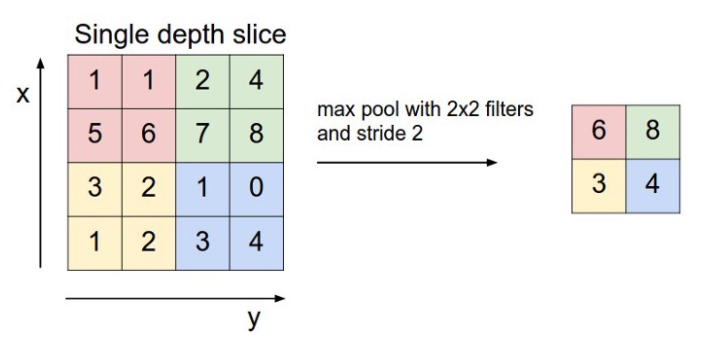
And the last thing is using the fully connected layer to classify those features wich not our case in the Faster RCNN.

### Part 2 : Region Proposel Network (RPN)
RPN is small neural network sliding on the last feature map of the convolution layers and predict wether there is an object or not and also predict the bounding box of those objects. 
- The RPN is usually a simple network with a 3 convolutional layers. There is one common layer which feeds into a two layers — one for classification and the other for bounding box regression   
- The purpose of RPN is to generate a number of bounding boxes called Region of Interests ( ROIs) that has high probability of containing any object.  
- The output from this network is a number of bounding boxes identified by the pixel co-ordinates of two diagonal corners, and a value (1, 0, or -1, indicating whether an object is in the bounding box or not or the box can be ignored respectively ).  
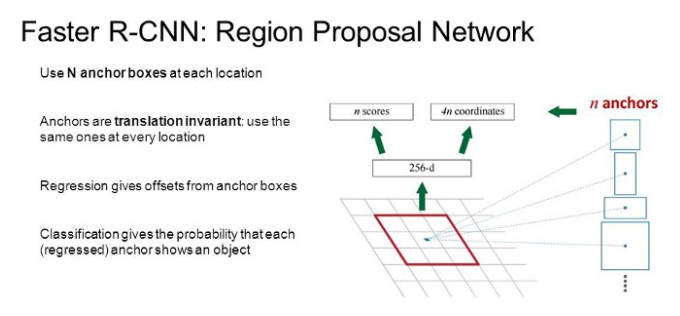  
### Part 3 : Classes and Bounding Boxes prediction /Detection network  
Now we use another Fully connected neural networks that takes as an input the regions proposed by the RPN and predict object class ( classification) and Bounding boxes (Regression).    
- The Detection Network ( sometimes also called the RCNN network ) takes input from both the Feature Network and RPN , and generates the final class and bounding box.  
- It is normally composed of 4 Fully Connected or Dense layers  
- There are 2 stacked common layers shared by a classification layer and a bounding box regression layer. To help it classify only the inside of the bounding boxes, the features are cropped according to the bounding boxes.  
#### Training
To train this architecture, we use SGD to optimize convolution layers filters, RPN weights and the last fully connected layer weights.  

# Training the RPN

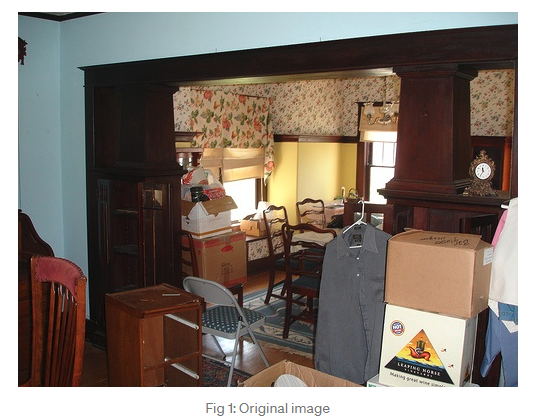

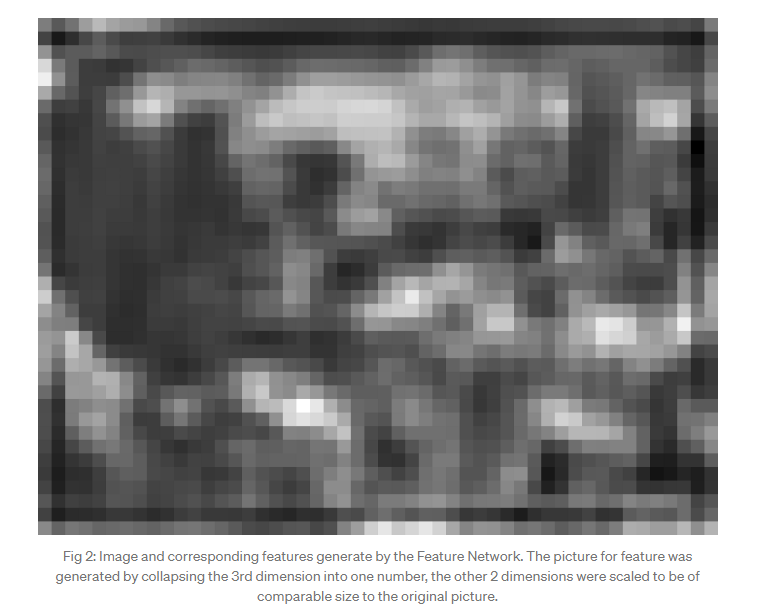
- For training the RPN, first a number of bounding boxes are generated by a mechanism called anchor boxes. Every ‘pixel’ of the feature image is considered an anchor. Each anchor corresponds to a larger set of squares of pixel in the original image ( some reshaping is usually done on the original image before feature extraction) 
- anchors are positioned uniformly across both dimensions of the (reshaped) image. The input that is required from the feature generation layer to generate anchor boxes is the shape of the tensor, not the full feature tensor itself. 

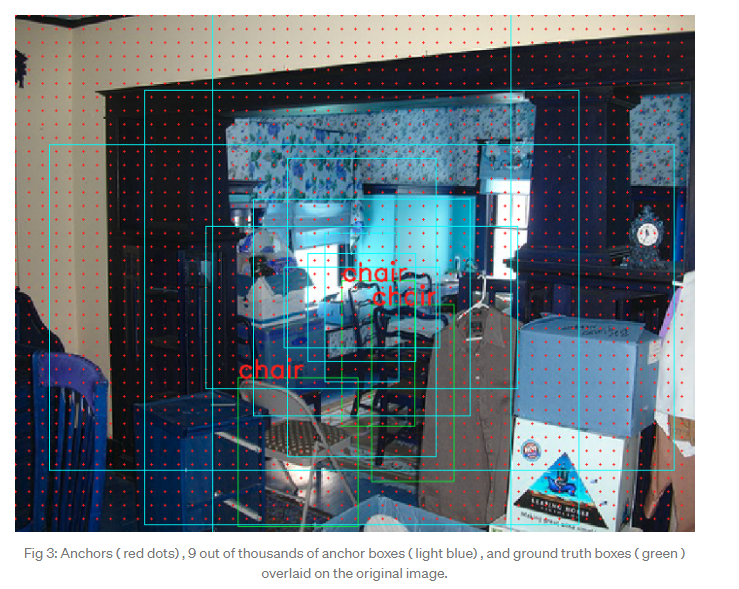
- A number of rectangular boxes of different shapes and sizes are generated centered on each anchor. Usually 9 boxes are generated per anchor (3 sizes x 3 shapes) as shown in Fig 4. Hence, there are 10s of thousands of anchor boxes per image. For example in Fig 1, 38x57x9 = 19494 anchor boxes are generated.

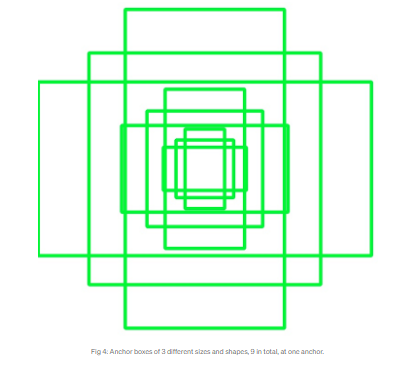
- In the fist step of reduction an operation called Non-Maximum Suppression ( NMS) is used. NMS removes boxes that overlaps with other boxes that has higher scores ( scores are unnormalized probabilities , e.g. before softmax is applied to normalize)   
-  About 2000 boxes are extracted during training phase ( the number is lower, about 300 for testing phase)  
- In the testing phase these boxes along with their scores go straight to the Detection Network.  
- In the training phase the 2000 boxes are further reduced through sampling to about 256 before entering the Detection Network.  
- To generate labels for RPN classification ( e.g. foreground , background , and ignore ), IOU of all the bounding boxes against all the ground truth boxes are taken.  
-  Then the IOUs are used to label the 256 ROIs as foreground and background, and ignored. These labels are then used to calculate the cross-entropy loss, after first removing the ignored (-1) class boxes.  
- In addition to classification, the RPN also tries to tighten the center and the size of the anchor boxes around the target. This is called the bounding box regression.  
-  For this to happen, targets needs to be generated, and losses needs to be calculated for back propagation. The distance vector from the center of the ground truth box to the anchor box is taken and normalized to the size of the anchor box. That is the target delta vector for the center.   
- The size target is the log of the ratio of size of each dimension of the ground truth over anchor box. The loss is calculated by using an expression called Smooth L1 Loss .  
-  The regular L1 loss ( e.g. the norm or absolute value) is not differentiable at 0. Smooth L1 Loss overcomes this by using L2 loss near 0. The extent of L2 loss is tuned by a parameter called sigma.   

# Training the Detection Network  
- The Detection Network can be considered the removed layers (top ) of the classification network that is used for features generation. Hence the starting weights can be pre-loaded from that network before training.  
- Training the Detection Network is similar to that of RPN. First, IOUs of all the 2000 or so ROIs generated by the NMS following RPN against each ground truth bounding box is calculated. Then the ROIs are labeled as foreground or background depending on the corresponding threshold values. Then a fixed number ( e.g. 256 ) ROIs are selected from the foreground and background ones. If there are not enough foreground and/or background ROIs to fill the fixed number, then some ROIs are duplicated at random.   
- The features are cropped ( and scaled ) to 14x14 (eventually max-pooled to 7x7 before entering the Detection Network ) according to the size of the ROIs (for this, ROI width and heights are scaled to the feature size). Fig 4 shows examples of ROIs overlaid on the feature image. The set of cropped features for each image are passed through the Detection Network as a batch.The final dense layers output for each cropped feature, the score and bounding box for each class ( e.g. 256 x C, 256x4C in one-hot encoding form, where C is the number of classes) .  
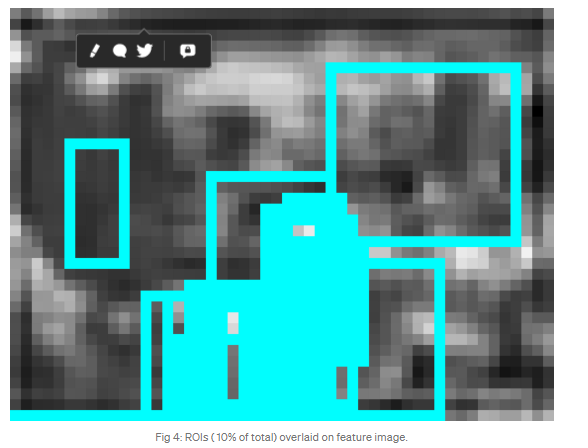
- To generate label for Detection Network classification, IOUs of all the ROIs and the ground truth boxes are calculated . Depending on IOU thresholds ( e.g. foreground above 0.5 , and background between 0.5 and 0.1), labels are generated for a subset of ROIs. The difference with RPN is that here there are more classes. Classes are encoded in sparse form, instead of one-hot encoding. Following a similar approach to the RPN target generation, bounding box targets are also generated. However, these targets are in the compact form as mentioned previously, hence are expanded to the one-hot encoding for calculation of loss.  
- The loss calculation is again similar to that of the RPN network. For classification sparse cross-entropy is used and for bounding boxes , Smooth L1 Loss is used. The difference with RPN loss is that there are more classes (say 20 including background) to consider instead of just 2 (foreground and background)  

# faster rcnn from second website

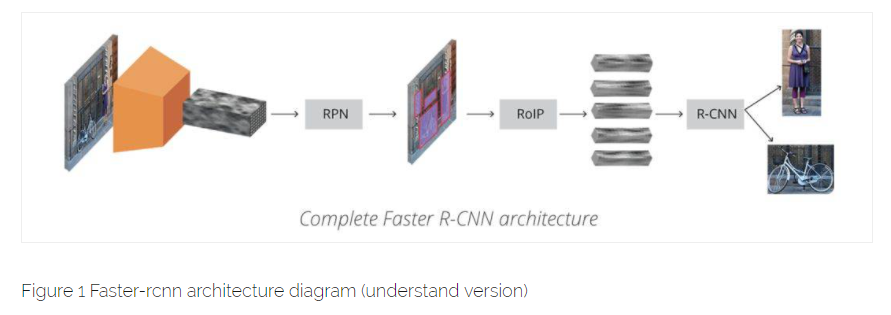

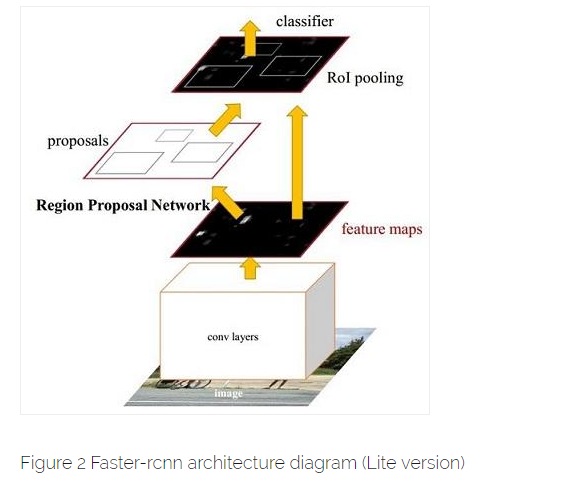

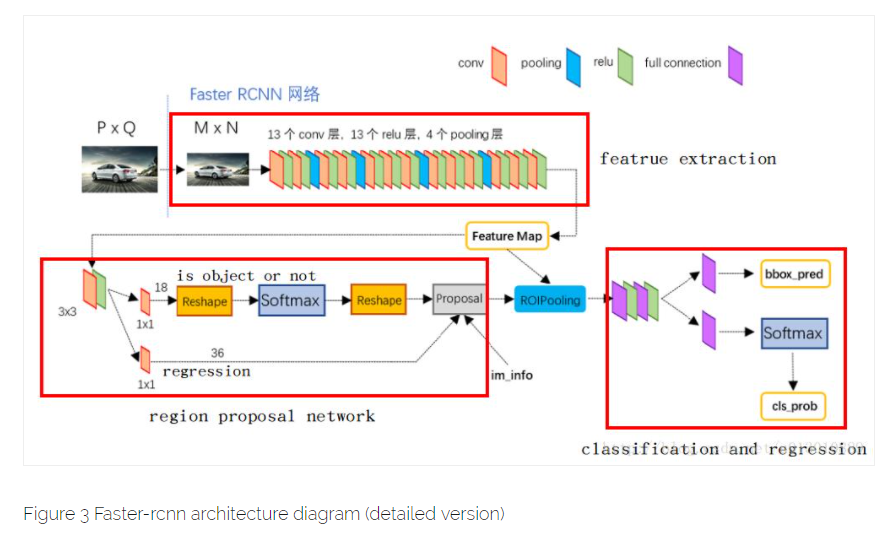

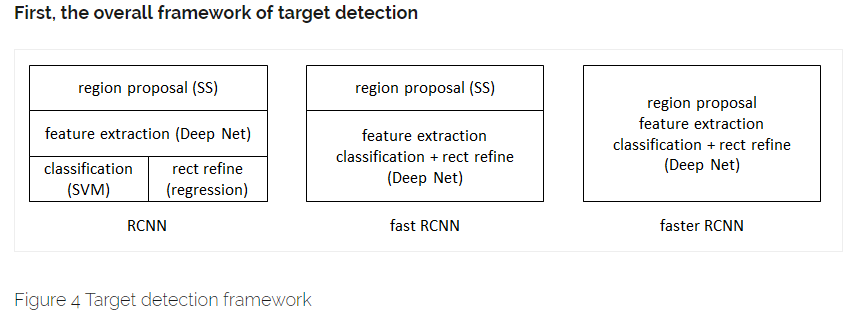

- Looking at Figure 4, you can see that the target detection framework contains four key modules, including region proposal (generating ROI), feature extraction (feature extraction network), classification (ROI classification), and regression (ROI regression).     
- The faster-rcnn combines these four modules with a neural network to train an end-to-end network. By observing Figure 1, Figure 2, Figure 3, we can get the following conclusion: Faster-rcnn mainly includes 4 key modules.Feature extraction network, generation ROI, ROI classification, ROI regression。

**1. Feature extraction network :** It is used to extract important features of different targets from a large number of images. It is usually composed of conv+relu+pool layer. Some pre-trained networks (VGG, Inception, Resnet, etc.) are commonly used. The result obtained is called feature map. ;   

**2. Generate ROI:** Make multiple candidate ROIs at each point of the obtained feature map (here is 9), and then use the classifier to distinguish these ROIs into background and foreground, and use the regression to make preliminary adjustments to the positions of these ROIs;   

**3. ROI classification:** In the RPN phase, used to distinguish between foreground (overlap of real target and overlap area greater than 0.5) and background (not overlapping with any target or overlapping area less than 0.1); in the Fast-rcnn phase, to distinguish between different kinds of targets (cats, dogs, people, etc.);  

**4. ROI regression:** In the RPN phase, make preliminary adjustments; make precise adjustments in the Fast-rcnn phase;

**In short, the overall process is as follows：**

- First, the input picture is cropped, and the cropped picture is sent to the pre-trained classification network to obtain the feature map corresponding to the image;  
- Then take 9 candidate ROIs (3 different scales, 3 different aspect ratios) on each anchor point on the feature map, and map them to the original image according to the corresponding scale (because the feature extraction network generally has Conv and pool are composed, but only the pool will change the size of the feature map, so the final feature map size is related to the number of pools);
- These candidate ROIs are then input into the RPN network, which classifies the ROIs (ie, determine whether these ROIs are foreground or background) and performs a preliminary regression (ie, calculates the deviation of the BB between these foreground ROIs and the real target). Value, includingΔx、Δy、Δw、Δh), then do NMS (non-maximum suppression, that is, sort the ROI according to the score of the classification, and then select the first N ROIs);
- Then perform ROI Pooling operations on these different sizes of ROIs (that is, map them to a specific size feature_map, which is 7x7 in the text), and output a fixed size feature_map;
- Finally, it is input into a simple detection network, and then classified by 1x1 convolution (differentiating different categories, N+1 class, redundant class is background for deleting inaccurate ROI), and BB regression is performed at the same time. Accurately adjust the deviation between the predicted ROI and the GT's ROI) to output a BB set.

**Second, the core problem in Faster-rcnn**

- 1. Proposed an "RPN" network to increase the speed while improving accuracy;

- 2. Feature sharing and training of RPN network and Fast-rcnn network;

- 3. Using ROI Pooling technology;

- 4. The use of NMS technology;

**Anchor point**  
- the minimum unit point on the feature map, such as the size of the original image is 256x256, the feature extraction network contains 4 pool layers, and then the size of the feature map finally obtained is 256/16 x 256/16, that is, a 16x16 feature is obtained. In the figure, the smallest unit in the figure is the anchor point. Due to the proportional relationship between the feature image and the original image, the dense dots on the feature map correspond to the interval of 16 pixels above the original image, as shown in the following figure:  
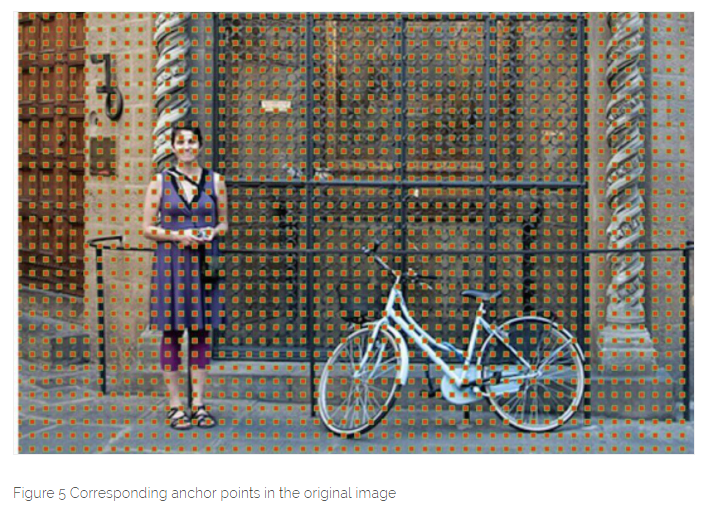

## 2. Candidate ROI  
- For each anchor point, then generate 9 BBs according to different scales (128, 256, 512pixel) and different aspect ratios (1:1, 0.5:1, 1:0.5), as shown in the figure below, for 16x16 The feature map ultimately produces 16x16x9 candidate ROIs.

**Anchor boxes** 
- Anchor boxes are a set of predefined bounding boxes of a certain height and width. These boxes are defined to capture the scale and aspect ratio of specific object classes you want to detect and are typically chosen based on object sizes in your training datasets. 

**aspect ratio** 
- The aspect ratio of a geometric shape is the ratio of its sizes in different dimensions. For example, the aspect ratio of a rectangle is the ratio of its longer side to its shorter side – the ratio of width to height, when the rectangle is oriented as a "landscape".  
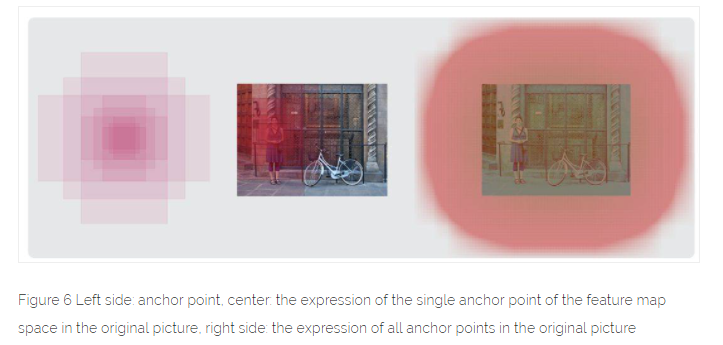

##  RPN network -- used to distinguish and initially locate multiple ROIs generated on the feature map:
 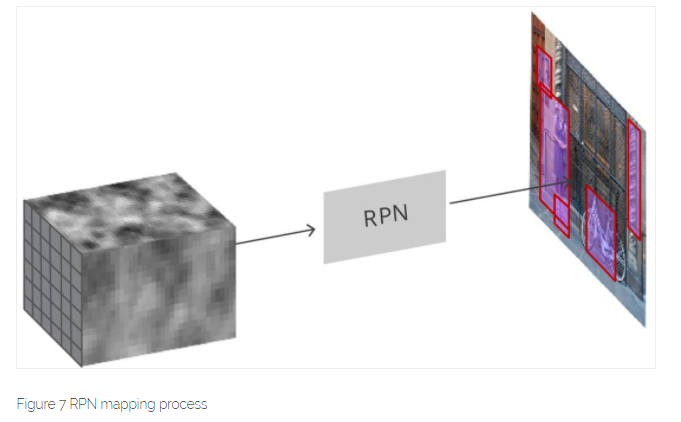
 Figure 7 RPN mapping process  

- The RPN (shown in Figure 3) is efficiently implemented in a full convolution, with the convolutional feature map returned by the underlying network as input. First, we use a convolutional layer with 512 channels and a 3x3 convolution kernel size. Then we have two parallel convolutional layers that use a 1x1 convolution kernel. The number of channels depends on the number of anchors per point.

- For the classification layer, we output two predictions for each anchor point: it is the score of the background (not the target), and it is the score of the foreground (actual target).

- For the regression or border adjustment layer, we output four predictions: Δx, Δy, Δw, Δh. We will use these values ​​in the anchor to get the final recommendation.

## ROI Pooling 
- The role of ROI Pooling is to fix the ROI above the feature map to a feature map of specific size (7x7) through the maximum pooling operation for subsequent classification and bounding box regression operations.

### problem 
- Since the position of the preselected ROI is usually obtained by model regression, it is generally a floating point number, and the redistributed feature map requires a fixed scale. Therefore, there are two data quantization processes in the ROI Pooling operation. 1) quantize the boundary of the candidate frame to the integer point coordinate value; 2) divide the quantized boundary region into kxk units, and quantize the boundary of each unit. In fact, after the above two quantization operations, there is a certain deviation between the ROI and the initial ROI, which will affect the accuracy of the detection.  
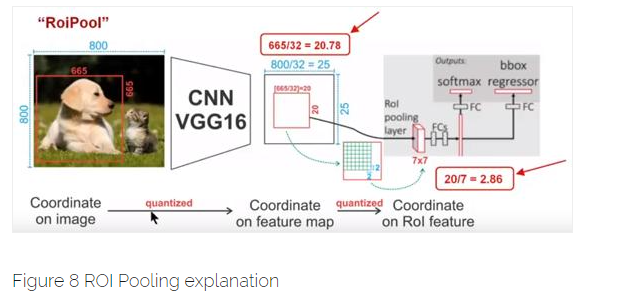
- Below we use a visual example to analyze the regional mismatch problem, as shown in the figure, this is a Faster-rcnn detection framework. Enter a picture of 800x800 with a 665x665 BB in the box. After the image has passed through the feature extraction network, the feature map of the entire image becomes 800/32 * 800/32, which is 25x25, but 665/32 = 20.87, with decimals, and the ROI Pooling directly quantizes it to 20. A deviation was introduced here. Since the size of the final feature map is 7x7, that is, the area of ​​20x20 needs to be mapped to 7x7, the side of the rectangular area is 2.86, which is again quantized to 2. Here again a quantization error is introduced. After these two quantifications, the candidate ROI has experienced a serious deviation (as shown in the green part of the figure). More importantly, there is a difference of 0.1 pixels on the feature map, which corresponds to 3.2 pixels on the original image.

## Detection network after ROI Pooling  
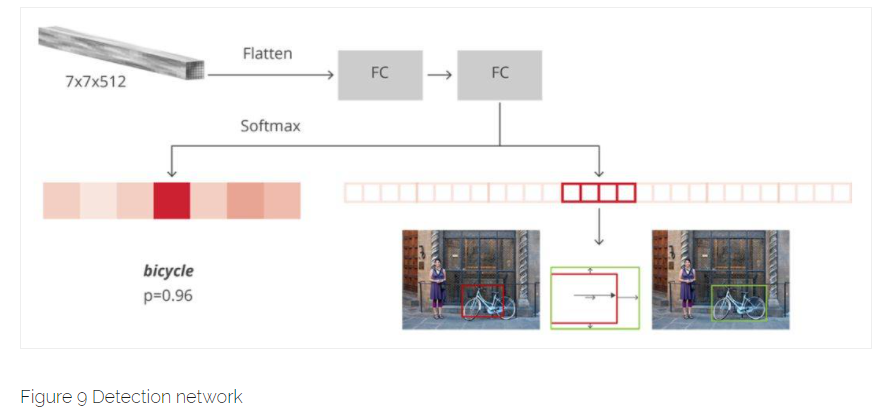
- As shown in the figure above, after obtaining the feature map of 7x7x512, it is expanded into a one-dimensional vector by the Flatten operation, and then classified and regressed through two fully connected layers. A fully connected layer with N+1 units, where N is the total number of classes and the other is the background class. A fully connected layer with 4N units. We want to have a regression forecast, so we need Δx, Δy, Δw, Δh for each of the N categories.

## NMS (non-maximum suppression) 
- Since anchor points often overlap, it is recommended that they eventually overlap on the same goal. To solve the problem of repeated suggestions, we use a simple algorithm called non-maximum suppression (NMS). The NMS gets a list of suggestions sorted by score and iterates over the sorted list, discarding those recommendations where the IoU value is greater than a predefined threshold and suggests a higher score   

. Sort the scores of all candidate boxes, select the highest score and its corresponding BB;  
. Traverse the remaining boxes and if it overlaps the current highest score box by more than a certain threshold, we remove    it.    
. Repeat the above process by continuing to select the highest score from the unprocessed box.  

##  Loss function calculation  
- For each anchor point, first add a second-class softmax followed by 2 score outputs to indicate whether this is a foreground or a background probability (p_i), and then connected to the regressor output of a bounding box to represent the four coordinate positions of the anchor point (t_i), so the overall Loss function of RPN can be defined as:  

- i represents the i-th anchor point, when the anchor point is a positive beiji samplep_i^*=1, which is 0 for negative samples.t_i^*Represents a ground true box coordinate associated with a positive sample anchor (each positive sample anchor may only correspond to a ground true box: a positive sample anchor corresponds to a grand true BB, then the anchor and ground true box The IOU is either the largest of all anchors or greater than 0.7).  

- x, y, w, h represent the center coordinates, width and height of the box, respectively;x,x_a,x^*Indicates predicted box, anchor box, and ground truth box, as shown in the following figure;t_iIndicates the offset of the predict box relative to the anchor box;t_i^*Represents the offset of the ground true box relative to the anchor box. The goal of learning is to get the former closer to the latter value.  

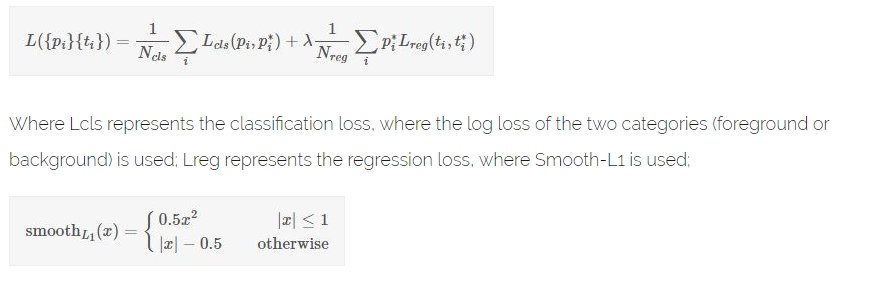
## Division of positive and negative samples 
- For each scaled ground true box area, the anchor with the largest overlap ratio is recorded as a positive sample (guarantee that each ground true corresponds to at least one positive sample anchor);
- For 1) the remaining anchor, if it overlaps with a certain calibration area by more than 0.7, it is recorded as a positive sample (each ground true box may correspond to multiple positive sample anchors. But each positive sample anchor may only correspond to one grand true Box); if it overlaps with any of the calibrations, the ratio is less than 0.3, which is recorded as a negative sample.
- For the remaining anchors of the above two steps, discard them;
- An anchor that crosses the boundaries of the image is discarded.

# what is difference between RCNN, Fast RCNN and Faster RCNN
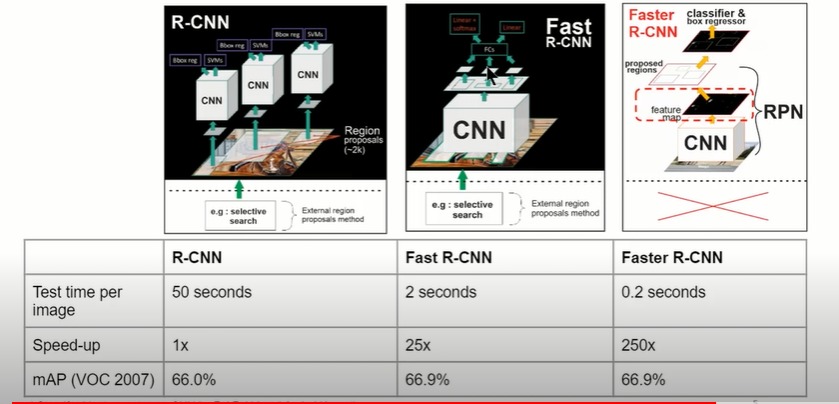
- Faster RCNN is the modified version of Fast RCNN. The major difference between them is that Fast RCNN and RCNN uses selective search for generating Regions of Interest, while Faster RCNN uses “Region Proposal Network”, aka RPN 

**slective Search:** is a region proposal algorithm used in object detection. It is designed to be fast with a very high                         recall. It is based on computing hierarchical grouping of similar regions based on color, texture, size                     and shape compatibility.

# Why faster RCNN is faster than fast RCNN?
The reason “Fast R-CNN” is faster than R-CNN is because you don't have to feed 2000 region proposals to the convolutional neural network every time. Instead, the convolution operation is done only once per image and a feature map is generated from it  

https://www.geeksforgeeks.org/r-cnn-vs-fast-r-cnn-vs-faster-r-cnn-ml/

# R-CNN:   
- R-CNN was proposed by Ross Girshick et al. in 2014 to deal with the problem of efficient object localization in object detection. The previous methods use what is called Exhaustive Search which uses sliding windows of different scales on image to propose region proposals Instead, this paper uses the Selective search algorithm which takes advantage of segmentation of objects and Exhaustive search to efficiently determine the region proposals.
- <span class="mark">This selective search algorithm proposes approximately 2000 region proposals per image</span>. These are then passed to the CNN model (Here AlexNet is used). 
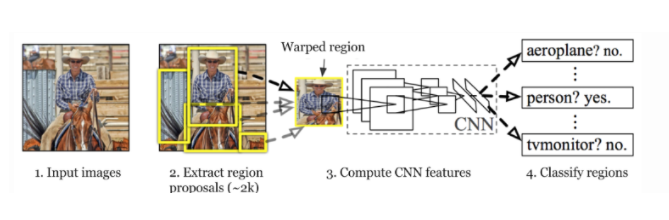
- This CNN model then outputs a (1, 4096) feature vector from each region proposal. This vector then passed into the SVM model for classification of object and bounding box regressor for localization.

**Problem with R-CNN:**

- Each image needs to classify 2000 region proposals. So, it takes a lot of time to train the network.
- It requires 49 seconds to detect the objects in an image on GPU.
- To store the feature map of the region proposal, lots of Disk space is also required.

# Fast R-CNN : 
- In R-CNN we passed each region proposal one by one in the CNN architecture and selective search generated around 2000 region proposal for an image. So, it is computationally expensive to train and even test the image using R-CNN.
- To deal with this problem Fast R-CNN was proposed, It takes the whole image and region proposals as input in its CNN architecture in one forward propagation. It also combines different parts of architecture (such as ConvNet, RoI pooling, and classification layer) in one complete architecture. That also removes the requirement to store a feature map and saves disk space. 
- It also uses the softmax layer instead of SVM in its classification of region proposal which proved to be faster and generate better accuracy than SVM.
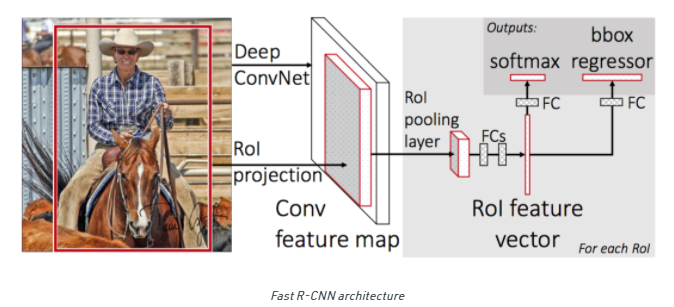

- Fast R-CNN drastically improves the training (8.75 hrs vs 84 hrs) and detection time from R-CNN. It also improves Mean Average Precision (mAP) marginally as compare to R-CNN.   

**Problems with Fast R-CNN:**   
- Most of the time taken by Fast R-CNN during detection is a selective search region proposal generation algorithm. Hence, it is the bottleneck of this architecture which was dealt with in Faster R-CNN.

# Faster R-CNN:  
- <span class="mark">Faster R-CNN was introduced in 2015 by k He et al. After the Fast R-CNN, the bottleneck of the architecture is selective search. Since it needs to generate 2000 proposals per image. It constitutes a major part of the training time of the whole architecture.</span> 
- In Faster R-CNN, it was replaced by the region proposal network. First of all, in this network, we passed the image into the backbone network. This backbone network generates a convolution feature map. These feature maps are then passed into the region proposal network. The region proposal network takes a feature map and generates the anchors (the centre of the sliding window with a unique size and scale). These anchors are then passed into the classification layer (which classifies that there is an object or not) and the regression layer (which localize the bounding box associated with an object).
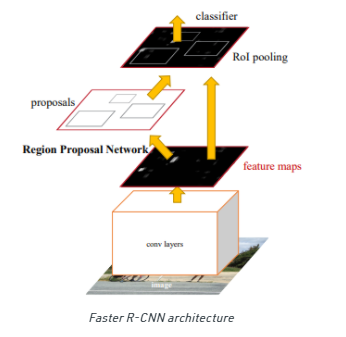